<a href="https://colab.research.google.com/github/KingMZ01/Environmental-Monitoring/blob/main/Air_Quality_Prediction_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Air Pollution Prediction and Model Comparison

This notebook demonstrates the use of machine learning models to monitor and predict air pollution levels.

We will explore data preprocessing, train multiple models including XGBoost and Random Forest, and compare their performance.


#Step-1. Data Collection & Setup

##Part 1 — Install packages (run this first)

In [2]:
# install packages (run once)
!pip install --quiet kaggle pandas numpy scikit-learn matplotlib seaborn joblib


##Part 2 — Get Kaggle API credentials (kaggle.json)

Upload kaggle.json directly

In [3]:
#interactive upload of kaggle.json
from google.colab import files
print("Please upload the kaggle.json you downloaded from your Kaggle account.")
uploaded = files.upload()  # this will open a file picker

Please upload the kaggle.json you downloaded from your Kaggle account.


Saving kaggle.json to kaggle.json


In [4]:
# After upload, move it to ~/.kaggle and set permissions
import os
if 'kaggle.json' in uploaded:
    os.makedirs('/root/.kaggle', exist_ok=True)
    !cp kaggle.json /root/.kaggle/
    !chmod 600 /root/.kaggle/kaggle.json
    print("kaggle.json installed.")
else:
    print("kaggle.json not found. Upload failed or you canceled.")


kaggle.json installed.


##Part 3 — Download Dataset (Beijing PM2.5)

In [5]:
#download & unzip dataset to /content/data
DATA_DIR = "/content/data"
!mkdir -p $DATA_DIR

# Kaggle dataset slug (one widely used PRSA copy)
!kaggle datasets download -d djhavera/beijing-pm25-data-data-set -p $DATA_DIR --unzip


Dataset URL: https://www.kaggle.com/datasets/djhavera/beijing-pm25-data-data-set
License(s): CC0-1.0
  0% 0.00/505k [00:00<?, ?B/s]
100% 505k/505k [00:00<00:00, 783MB/s]


#Step-2. Data Preparation

##Part 4 — Load Data & Quick Look
Quick look at the CSV (load into pandas and show columns)

In [6]:
# import pandas as pd
# df = pd.read_csv('PRSA_data_2010.1.1-2014.12.31.csv')

# print(df.head())

In [7]:
#load CSV and inspect
import pandas as pd
CSV_PATH = "/content/data/PRSA_data_2010.1.1-2014.12.31.csv"
df = pd.read_csv(CSV_PATH)
print("Rows / Columns:", df.shape)
print("Columns:", df.columns.tolist())
df.head(7)


Rows / Columns: (43824, 13)
Columns: ['No', 'year', 'month', 'day', 'hour', 'pm2.5', 'DEWP', 'TEMP', 'PRES', 'cbwd', 'Iws', 'Is', 'Ir']


,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0
5,6,2010,1,1,5,NaN,-19,-10.0,1017.0,NW,16.10,0,0
6,7,2010,1,1,6,NaN,-19,-9.0,1017.0,NW,19.23,0,0


##Part 5 — Cleaning & Datetime Index
Build a proper datetime index and basic cleaning

In [8]:
#datetime + missing-value summary
# create a datetime column (hour is 0-23)
df['datetime'] = pd.to_datetime(
    df['year'].astype(str) + '-' +
    df['month'].astype(str).str.zfill(2) + '-' +
    df['day'].astype(str).str.zfill(2) + ' ' +
    df['hour'].astype(str).str.zfill(2) + ':00'
)

df = df.set_index('datetime').sort_index()
print("Time span:", df.index.min(), "to", df.index.max())
print("\nMissing values per column:")
print(df.isna().sum())


Time span: 2010-01-01 00:00:00 to 2014-12-31 23:00:00

Missing values per column:
No          0
year        0
month       0
day         0
hour        0
pm2.5    2067
DEWP        0
TEMP        0
PRES        0
cbwd        0
Iws         0
Is          0
Ir          0
dtype: int64


##Part 6 — Exploratory Data Analysis (EDA)
Simple exploratory plots (see pm2.5 distribution & time series)

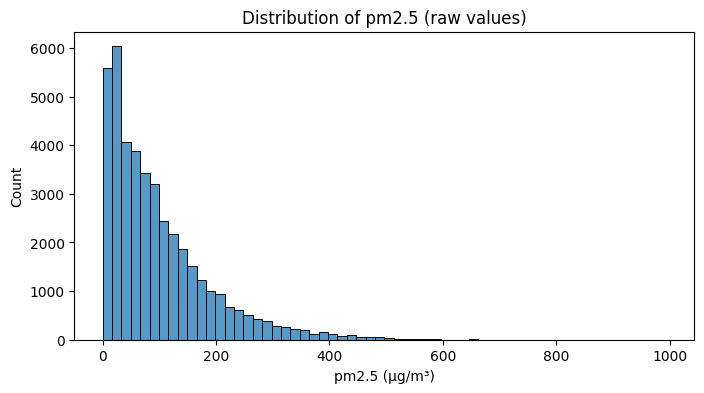

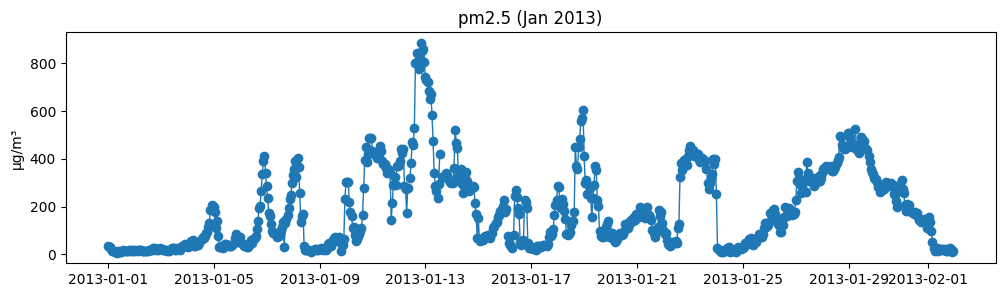

In [9]:
#quick plots
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# pm2.5 histogram (dropna)
plt.figure(figsize=(8,4))
sns.histplot(df['pm2.5'].dropna(), bins=60, kde=False)
plt.title("Distribution of pm2.5 (raw values)")
plt.xlabel("pm2.5 (µg/m³)")
plt.show()

# small timeseries slice (one month)
sample = df['2013-01-01':'2013-02-01']['pm2.5']
plt.figure(figsize=(12,3))
plt.plot(sample.index, sample.values, marker='o', linewidth=1)
plt.title("pm2.5 (Jan 2013)")
plt.ylabel("µg/m³")
plt.show()


#Step-3. Feature Engineering

##Part 7 — Prepare Target (t+1)
Prepare dataset for modeling (filter/clean + create target t+1)

In [10]:
#basic cleaning & create t+1 target
cols_keep = ['pm2.5','DEWP','TEMP','PRES','cbwd','Iws','Is','Ir']
df_model = df[cols_keep].copy()

# replace negative or obviously wrong pm2.5
df_model['pm2.5'] = df_model['pm2.5'].where(df_model['pm2.5'] >= 0)

# target: pm2.5 at next hour
df_model['pm25_t_plus_1'] = df_model['pm2.5'].shift(-1)

print("Rows before dropping missing target:", len(df_model))
df_model = df_model.dropna(subset=['pm25_t_plus_1'])
print("Rows after dropping missing target:", len(df_model))
df_model.head()


Rows before dropping missing target: 43824
Rows after dropping missing target: 41757


,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,pm25_t_plus_1
datetime,,,,,,,,,
2010-01-01 23:00:00,NaN,-17,-5.0,1020.0,cv,0.89,0,0,129.0
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0,148.0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0,159.0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0,181.0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0,138.0


##Part 8 — Create Features (lags, rolling, time, wind encoding)
Feature engineering (lags, rolling stats, time features, encode wind direction)

In [11]:
#feature engineering
import numpy as np

def add_features(df):
    g = df.copy()
    # time features
    g['hour'] = g.index.hour
    g['dow'] = g.index.dayofweek
    g['month'] = g.index.month
    # cyclic encode hour
    g['hour_sin'] = np.sin(2*np.pi*g['hour']/24)
    g['hour_cos'] = np.cos(2*np.pi*g['hour']/24)

    # lag features of pm2.5
    for lag in [1,3,6,12,24]:
        g[f'pm_lag_{lag}'] = g['pm2.5'].shift(lag)

    # rolling means
    for w in [3,6,12,24]:
        g[f'pm_roll_{w}'] = g['pm2.5'].rolling(window=w, min_periods=1).mean()

    # wind direction (cbwd) to one-hot
    g = pd.get_dummies(g, columns=['cbwd'], dummy_na=True)

    # fill small gaps in meteorological features (simple)
    for c in ['DEWP','TEMP','PRES','Iws','Is','Ir']:
        if c in g.columns:
            g[c] = g[c].interpolate(limit=3).bfill().ffill()


    return g

df_feat = add_features(df_model)
# drop rows where lagged features are NaN (the early rows)
df_feat = df_feat.dropna()
print("Rows after feature creation:", len(df_feat))
df_feat.head()


Rows after feature creation: 40536


,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir,pm25_t_plus_1,hour,dow,...,pm_lag_24,pm_roll_3,pm_roll_6,pm_roll_12,pm_roll_24,cbwd_NE,cbwd_NW,cbwd_SE,cbwd_cv,cbwd_nan
datetime,,,,,,,,,,,,,,,,,,,,,
2010-01-03 00:00:00,90.0,-7,-6.0,1027.0,58.56,4,0,63.0,0,6,...,129.0,124.000000,139.833333,150.666667,144.333333,False,False,True,False,False
2010-01-03 01:00:00,63.0,-8,-6.0,1026.0,61.69,5,0,65.0,1,6,...,148.0,93.000000,125.500000,142.250000,140.791667,False,False,True,False,False
2010-01-03 02:00:00,65.0,-8,-7.0,1026.0,65.71,6,0,55.0,2,6,...,159.0,72.666667,110.666667,134.500000,136.875000,False,False,True,False,False
2010-01-03 03:00:00,55.0,-8,-7.0,1025.0,68.84,7,0,65.0,3,6,...,181.0,61.000000,92.500000,126.250000,131.625000,False,False,True,False,False
2010-01-03 04:00:00,65.0,-8,-7.0,1024.0,72.86,8,0,83.0,4,6,...,138.0,61.666667,77.333333,118.416667,128.583333,False,False,True,False,False


##Part 9 — Feature Selection & Train/Test Split
Choose features & split train/test (time-aware split)

In [12]:
#define features and do chronological split
feature_cols = [c for c in df_feat.columns if c not in ['pm25_t_plus_1','pm2.5']]  # exclude raw target cols
print("Using feature count:", len(feature_cols))

X = df_feat[feature_cols]
y = df_feat['pm25_t_plus_1']

split = int(0.8 * len(X))
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]
print("Train / Test sizes:", X_train.shape[0], X_test.shape[0])


Using feature count: 25
Train / Test sizes: 32428 8108


#Step-4. Modeling

##Part 10 — Train XGBoost Baseline
Train an XGBoost baseline (with early stopping)

###(A)-Recommended: upgrade XGBoost

In [13]:
!pip install --upgrade xgboost
import xgboost as xgb
print("XGBoost version:", xgb.__version__)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 MB 10.4 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 3.0.4
    Uninstalling xgboost-3.0.4:
      Successfully uninstalled xgboost-3.0.4
XGBoost version: 3.0.5


###(B)-Train with Early Stopping (Using xgb.train)

In [14]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Convert datasets into DMatrix (XGBoost’s optimized data structure)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Set XGBoost parameters
params = {
    "objective": "reg:squarederror",  # regression
    "eval_metric": "rmse",            # evaluation metric
    "eta": 0.05,                      # learning rate
    "max_depth": 6,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "seed": 42
}

# Train model with early stopping
evals = [(dtrain, "train"), (dtest, "test")]
model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=500,           # max trees
    evals=evals,
    early_stopping_rounds=20,      # stop if no improvement for 20 rounds
    verbose_eval=True
)

# Predict on test set
y_pred = model.predict(dtest)

# Evaluate performance
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Test RMSE: {rmse:.2f}")
print(f"Test R²: {r2:.3f}")


[0]	train-rmse:87.89767	test-rmse:88.37578
[1]	train-rmse:84.11419	test-rmse:84.50340
[2]	train-rmse:80.50240	test-rmse:80.79428
[3]	train-rmse:77.20776	test-rmse:77.39731
[4]	train-rmse:73.98185	test-rmse:74.05403
[5]	train-rmse:70.93593	test-rmse:70.90301
[6]	train-rmse:68.04862	test-rmse:67.96270
[7]	train-rmse:65.34726	test-rmse:65.15263
[8]	train-rmse:62.90364	test-rmse:62.61850
[9]	train-rmse:60.50476	test-rmse:60.11757
[10]	train-rmse:58.25477	test-rmse:57.76679
[11]	train-rmse:56.11768	test-rmse:55.57945
[12]	train-rmse:54.10427	test-rmse:53.51222
[13]	train-rmse:52.21992	test-rmse:51.51060
[14]	train-rmse:50.45607	test-rmse:49.67751
[15]	train-rmse:48.79922	test-rmse:47.96740
[16]	train-rmse:47.23973	test-rmse:46.37939
[17]	train-rmse:45.77245	test-rmse:44.86214
[18]	train-rmse:44.39993	test-rmse:43.47239
[19]	train-rmse:43.11634	test-rmse:42.17301
[20]	train-rmse:41.94317	test-rmse:40.94451
[21]	train-rmse:40.83494	test-rmse:39.79110
[22]	train-rmse:39.79278	test-rmse:38.6996

##Part 11 — Train a Random Forest Baseline (Compare with XGBoost)

In [15]:
# Train a Random Forest Baseline

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Initialize Random Forest
rf_model = RandomForestRegressor(
    n_estimators=200,   # number of trees
    max_depth=None,     # let it grow fully
    random_state=42,
    n_jobs=-1           # use all CPU cores
)

# Train on training data
rf_model.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_test)

# Metrics
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("🌳 Random Forest Results:")
print("RMSE:", round(rmse_rf, 2))
print("MAE:", round(mae_rf, 2))
print("R²:", round(r2_rf, 3))

# Compare with XGBoost
print("\n🚀 XGBoost Results:")
print("RMSE:", round(rmse, 2))
# print("MAE:", round(mae_xgb, 2))
print("R²:", round(r2, 3))


🌳 Random Forest Results:
RMSE: 24.32
MAE: 14.34
R²: 0.931

🚀 XGBoost Results:
RMSE: 24.44
R²: 0.93


#Step-5. Model Evaluation

##Part 11 — Model Comparison Plot (XGBoost vs Random Forest)

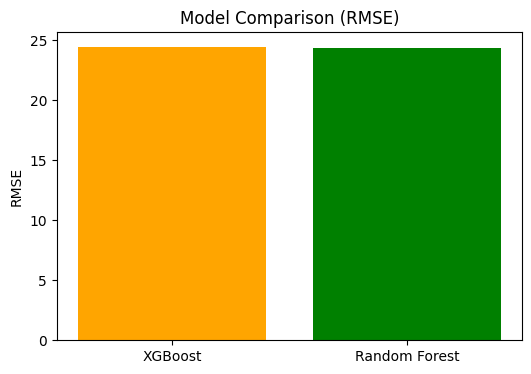

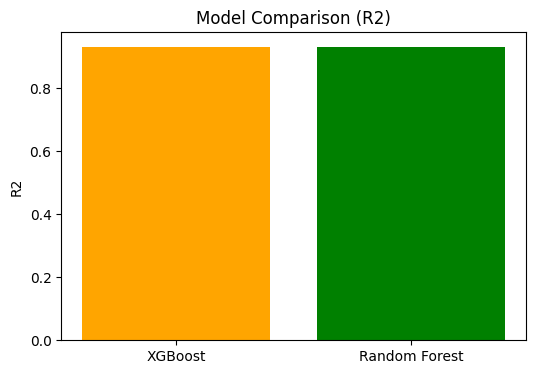

In [16]:
import matplotlib.pyplot as plt

# Collect results
models = ["XGBoost", "Random Forest"]
rmse_vals = [rmse, rmse_rf]
r2_vals = [r2, r2_rf]

# RMSE comparison
plt.figure(figsize=(6,4))
plt.bar(models, rmse_vals, color=["orange", "green"])
plt.ylabel("RMSE")
plt.title("Model Comparison (RMSE)")
plt.show()

# MAE comparison
plt.figure(figsize=(6,4))
plt.bar(models, r2_vals, color=["orange", "green"])
plt.ylabel("R2")
plt.title("Model Comparison (R2)")
plt.show()


##Part 12 — Evaluate Model-XGBoost


###1 — Feature Importance

Now we want to understand which features (TEMP, wind speed, pressure, etc.) are most important for predicting PM2.5

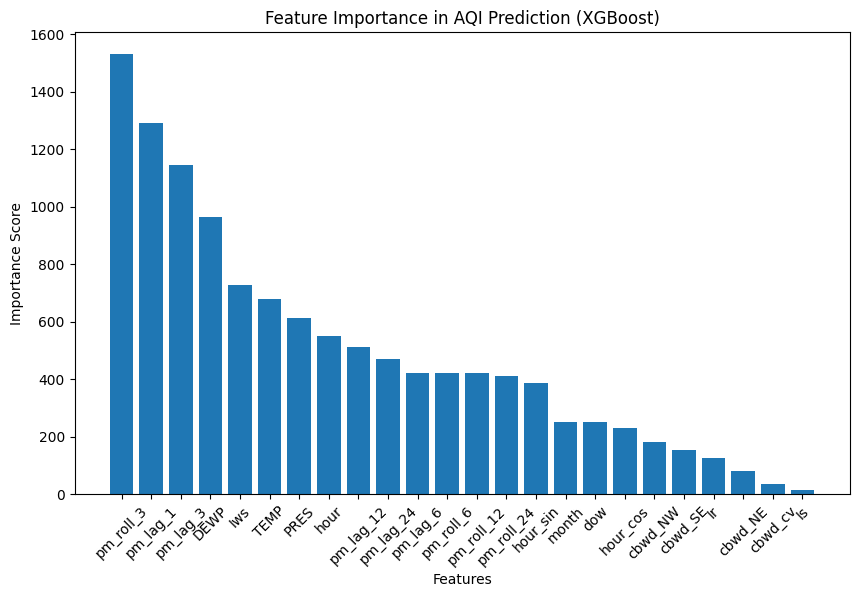

In [17]:
import matplotlib.pyplot as plt

# Get feature importance
importance = model.get_score(importance_type='weight')  # weight = number of times feature used in splits

# Sort features by importance
importance = dict(sorted(importance.items(), key=lambda x: x[1], reverse=True))

# Plot
plt.figure(figsize=(10,6))
plt.bar(range(len(importance)), list(importance.values()), align="center")
plt.xticks(range(len(importance)), list(importance.keys()), rotation=45)
plt.title("Feature Importance in AQI Prediction (XGBoost)")
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.show()


###2 — Predictions & Metrics


This is great for visually validating model accuracy.
It uses RMSE & MAE as metrics.

Test RMSE: 24.445 µg/m³, MAE: 14.403 µg/m³


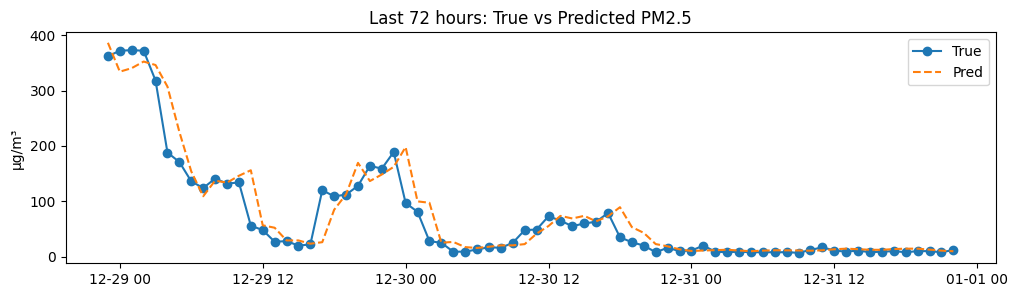

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

# Convert X_test into DMatrix (since model was trained with DMatrix)
dtest = xgb.DMatrix(X_test)

# Predict
y_pred = model.predict(dtest)

# Evaluation metrics
rmse = math.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
print(f"Test RMSE: {rmse:.3f} µg/m³, MAE: {mae:.3f} µg/m³")

# Plot true vs predicted for last 72 hours of test set
res = pd.DataFrame({'true': y_test, 'pred': y_pred}, index=y_test.index)
seg = res[-72:]
plt.figure(figsize=(12,3))
plt.plot(seg.index, seg['true'], label='True', marker='o')
plt.plot(seg.index, seg['pred'], label='Pred', linestyle='--')
plt.legend()
plt.title("Last 72 hours: True vs Predicted PM2.5")
plt.ylabel("µg/m³")
plt.show()


####(A) Time Series Plot (True vs Predicted)

Here we’ll compare true vs predicted PM2.5 over a 1-week period
Helps spot systematic biases (e.g., underestimation in high pollution episodes).

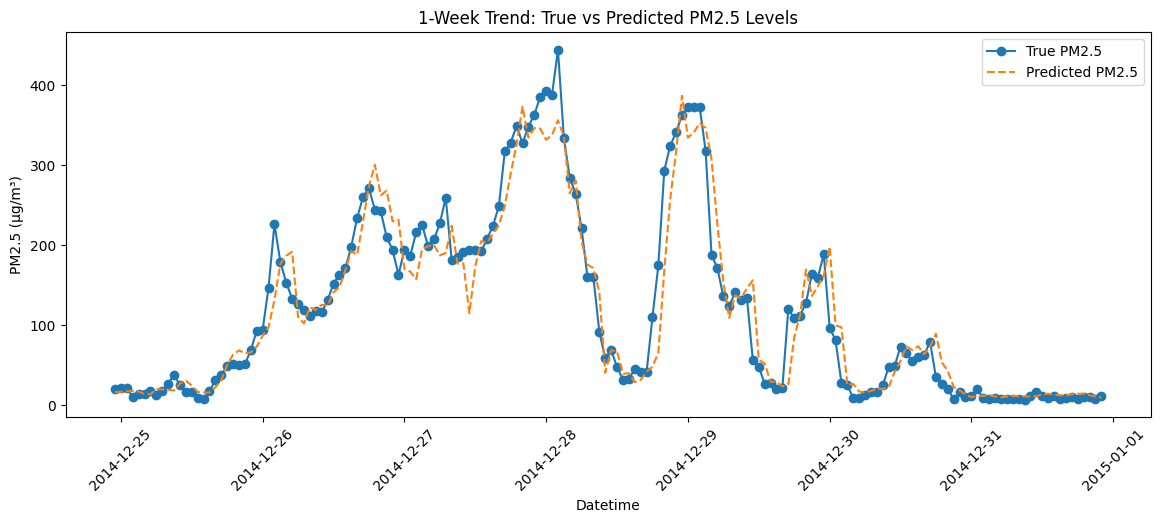

In [19]:
#Long-term comparison (example: 1 week)

# Select a slice of 7 days (168 hours) from the test set
week_segment = res[-168:]   # last 7 days in test set

plt.figure(figsize=(14,5))
plt.plot(week_segment.index, week_segment['true'], label='True PM2.5', marker='o')
plt.plot(week_segment.index, week_segment['pred'], label='Predicted PM2.5', linestyle='--')
plt.legend()
plt.title("1-Week Trend: True vs Predicted PM2.5 Levels")
plt.xlabel("Datetime")
plt.ylabel("PM2.5 (µg/m³)")
plt.xticks(rotation=45)
plt.show()


####(B) Scatter Plot (True vs Predicted)

Useful for detecting whether the model over/underpredicts at specific ranges (e.g., high PM2.5).

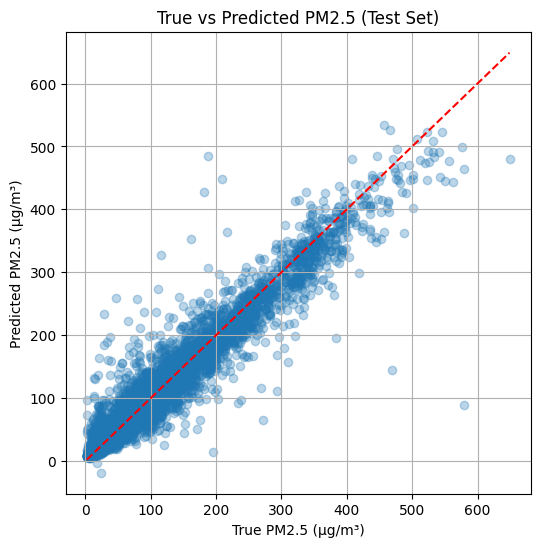

In [20]:
#Scatter plot to check correlation between true and predicted values
plt.figure(figsize=(6,6))
plt.scatter(res['true'], res['pred'], alpha=0.3)
plt.plot([res['true'].min(), res['true'].max()],
         [res['true'].min(), res['true'].max()],
         color='red', linestyle='--')  # 45-degree line (perfect prediction)
plt.title("True vs Predicted PM2.5 (Test Set)")
plt.xlabel("True PM2.5 (µg/m³)")
plt.ylabel("Predicted PM2.5 (µg/m³)")
plt.grid(True)
plt.show()


#Step-6. Air Quality Index (AQI) Analysis

##Part 13 — Convert PM2.5 → AQI (EPA breakpoints) and compute category accuracy

Category-level accuracy: 75.254%


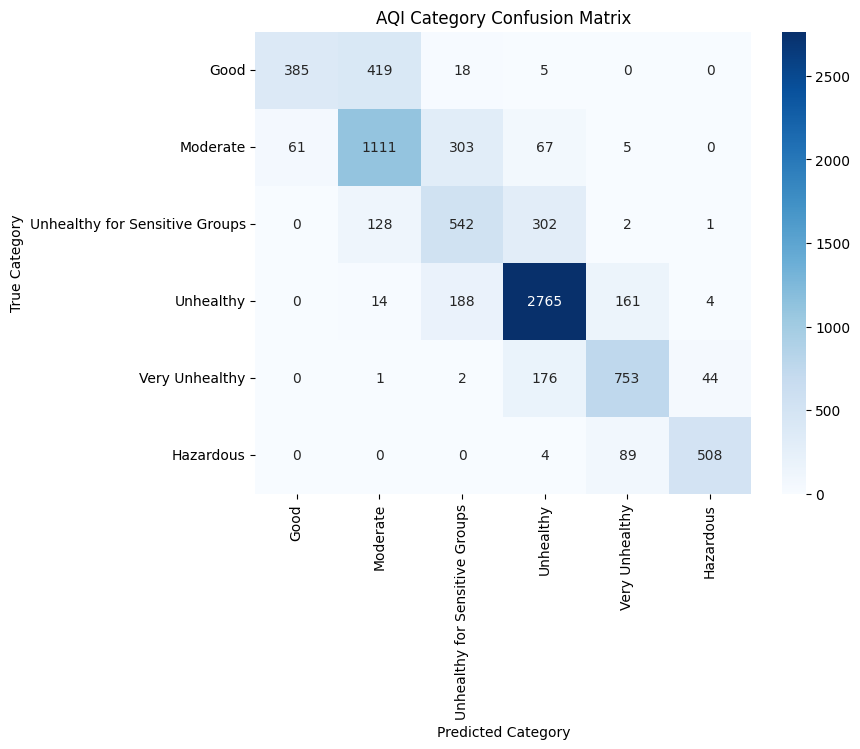

In [21]:
#PM2.5 → AQI conversion with safe category mapping

import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

# EPA AQI breakpoints for PM2.5 (µg/m³)
# Source: AirNow / EPA standard
# Breakpoints (EPA AirNow standard for PM2.5)
breakpoints = [
    (0.0, 12.0, 0, 50, "Good"),
    (12.1, 35.4, 51, 100, "Moderate"),
    (35.5, 55.4, 101, 150, "Unhealthy for Sensitive Groups"),
    (55.5, 150.4, 151, 200, "Unhealthy"),
    (150.5, 250.4, 201, 300, "Very Unhealthy"),
    (250.5, 500.4, 301, 500, "Hazardous")
]

def pm25_to_aqi(pm25):
    """Convert PM2.5 concentration to AQI using EPA formula"""
    for (c_low, c_high, aqi_low, aqi_high, category) in breakpoints:
        if c_low <= pm25 <= c_high:
            aqi = ((aqi_high - aqi_low) / (c_high - c_low)) * (pm25 - c_low) + aqi_low
            return round(aqi), category
    return None, "Unknown"  # Handle values outside breakpoint ranges

# Apply conversion
aqi_true = [pm25_to_aqi(v)[1] for v in y_test]
aqi_pred = [pm25_to_aqi(v)[1] for v in y_pred]

# Results DataFrame
aqi_res = pd.DataFrame({"true_cat": aqi_true, "pred_cat": aqi_pred}, index=y_test.index)

# Remove "Unknown" before confusion matrix
aqi_res = aqi_res[(aqi_res["true_cat"] != "Unknown") & (aqi_res["pred_cat"] != "Unknown")]

# Compute accuracy
# Compute AQI category accuracy
cat_acc = (aqi_res["true_cat"] == aqi_res["pred_cat"]).mean() * 100

print(f"Category-level accuracy: {cat_acc:.3f}%")

# Confusion matrix
cats = [bp[4] for bp in breakpoints]  # ordered categories
cm = confusion_matrix(aqi_res["true_cat"], aqi_res["pred_cat"], labels=cats)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=cats, yticklabels=cats)
plt.xlabel("Predicted Category")
plt.ylabel("True Category")
plt.title("AQI Category Confusion Matrix")
plt.show()


##Part 14 — Bar Chart of AQI Category Distribution

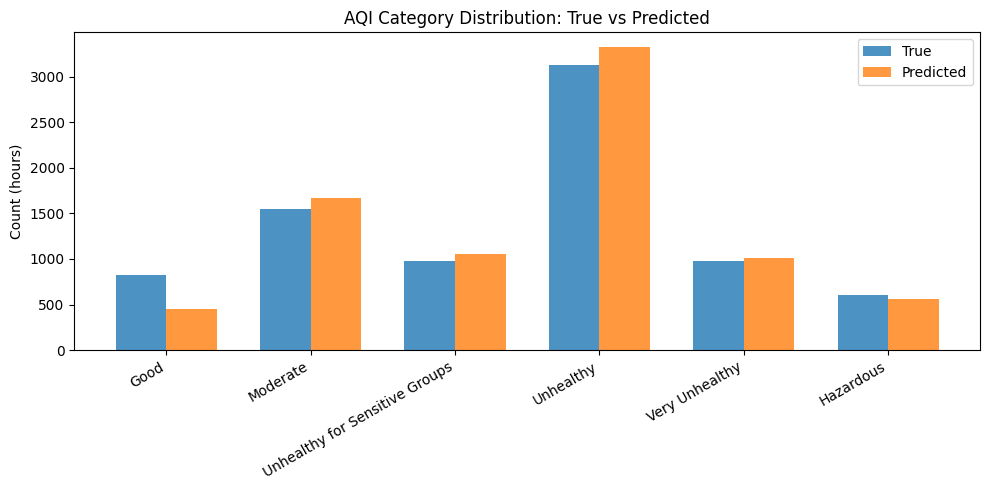

In [22]:
#Bar chart of category distribution (True vs Predicted)

import matplotlib.pyplot as plt

# Count categories
true_counts = aqi_res["true_cat"].value_counts().reindex(cats, fill_value=0)
pred_counts = aqi_res["pred_cat"].value_counts().reindex(cats, fill_value=0)

# Plot side-by-side bars
x = np.arange(len(cats))
width = 0.35

plt.figure(figsize=(10,5))
plt.bar(x - width/2, true_counts, width, label="True", alpha=0.8)
plt.bar(x + width/2, pred_counts, width, label="Predicted", alpha=0.8)

plt.xticks(x, cats, rotation=30, ha="right")
plt.ylabel("Count (hours)")
plt.title("AQI Category Distribution: True vs Predicted")
plt.legend()
plt.tight_layout()
plt.show()


#Step-7. Reporting & Deployment

##Part 15 — Generate PDF Report

We’ll use ReportLab (a professional PDF library) to combine:
*   Project title & dataset details
*   Model evaluation (RMSE, MAE, R²)
*   AQI category accuracy
*   Automatically embed your plots (last 72 hours, 1 week trend, scatter plot, confusion matrix, category bar chart)











In [23]:
#Generate PDF report with download link

!pip install reportlab

from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Image
from reportlab.lib.styles import getSampleStyleSheet
from reportlab.lib.units import inch
from sklearn.metrics import ConfusionMatrixDisplay

# --- 1. Define AQI categories (EPA standard) ---
aqi_cats = ["Good", "Moderate", "Unhealthy for Sensitive Groups",
            "Unhealthy", "Very Unhealthy", "Hazardous"]

# --- 2. Recompute important slices ---
res = pd.DataFrame({'true': y_test, 'pred': model.predict(xgb.DMatrix(X_test))}, index=y_test.index)
seg = res[-72:]       # Last 72h
week = res[-7*24:]    # Last 1 week

# Category counts (True vs Pred)
true_counts = aqi_res["true_cat"].value_counts().reindex(aqi_cats, fill_value=0)
pred_counts = aqi_res["pred_cat"].value_counts().reindex(aqi_cats, fill_value=0)
x = np.arange(len(aqi_cats))
width = 0.35

# --- 3. Save plots as images ---

plt.figure(figsize=(12,3))
plt.plot(seg.index, seg['true'], label='True', marker='o')
plt.plot(seg.index, seg['pred'], label='Pred', linestyle='--')
plt.legend(); plt.title("Last 72 hours: True vs Predicted PM2.5"); plt.ylabel("µg/m³")
plt.savefig("plot_72h.png"); plt.close()

plt.figure(figsize=(12,3))
plt.plot(week.index, week['true'], label='True')
plt.plot(week.index, week['pred'], label='Pred', linestyle='--')
plt.legend(); plt.title("1 week trend: True vs Predicted PM2.5")
plt.ylabel("µg/m³"); plt.xticks(rotation=45)
plt.savefig("plot_week.png"); plt.close()

plt.figure(figsize=(6,6))
plt.scatter(res['true'], res['pred'], alpha=0.3)
plt.plot([res['true'].min(), res['true'].max()],
         [res['true'].min(), res['true'].max()],
         color='red', linestyle='--')
plt.title("True vs Predicted PM2.5")
plt.xlabel("True PM2.5 (µg/m³)")
plt.ylabel("Predicted PM2.5 (µg/m³)")
plt.savefig("plot_scatter.png"); plt.close()

plt.figure(figsize=(8,6))
ConfusionMatrixDisplay.from_predictions(
    aqi_res["true_cat"], aqi_res["pred_cat"],
    labels=aqi_cats, cmap="Blues", xticks_rotation=30
)
plt.title("Confusion Matrix (AQI Categories)")
plt.savefig("plot_confusion.png"); plt.close()

plt.figure(figsize=(10,5))
plt.bar(x - width/2, true_counts, width, label="True", alpha=0.8)
plt.bar(x + width/2, pred_counts, width, label="Predicted", alpha=0.8)
plt.xticks(x, aqi_cats, rotation=30, ha="right")
plt.ylabel("Count (hours)")
plt.title("AQI Category Distribution")
plt.legend()
plt.savefig("plot_bar.png"); plt.close()

# --- 4. Build PDF ---
doc = SimpleDocTemplate("AQI_Model_Report.pdf")
styles = getSampleStyleSheet()
story = []

story.append(Paragraph("Air Quality Monitoring Project", styles['Title']))
story.append(Spacer(1, 0.2*inch))

story.append(Paragraph("Dataset: Beijing PM2.5 (2010–2014)", styles['Normal']))
story.append(Spacer(1, 0.1*inch))

story.append(Paragraph(f"Test RMSE: {rmse:.2f} µg/m³", styles['Normal']))
story.append(Paragraph(f"Test MAE: {mae:.2f} µg/m³", styles['Normal']))
story.append(Paragraph(f"Test R²: {r2:.3f}", styles['Normal']))
story.append(Paragraph(f"AQI Category Accuracy: {cat_acc:.2f}%", styles['Normal']))
story.append(Spacer(1, 0.3*inch))

story.append(Paragraph("Evaluation Plots:", styles['Heading2']))
story.append(Spacer(1, 0.2*inch))

for img_file in ["plot_72h.png", "plot_week.png", "plot_scatter.png", "plot_confusion.png", "plot_bar.png"]:
    story.append(Image(img_file, width=6*inch, height=3*inch))
    story.append(Spacer(1, 0.2*inch))

doc.build(story)

print("✅ PDF report generated: AQI_Model_Report.pdf")

# --- 5. (Optional) Auto-download ---
from google.colab import files
files.download("AQI_Model_Report.pdf")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 29.2 MB/s eta 0:00:00
✅ PDF report generated: AQI_Model_Report.pdf


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 800x600 with 0 Axes>

##Part 16 — Save Trained Model & Feature List:

In [24]:
# ============================================
# Save Trained Model & Feature List
# ============================================

import joblib
import pandas as pd
import os
from google.colab import files

# Create local output directory
OUT_DIR = "/content/aqi_model_example"
os.makedirs(OUT_DIR, exist_ok=True)

# 1️⃣ Save trained model (joblib format — good for reloading in Colab/Python)
joblib.dump(model, os.path.join(OUT_DIR, "xgb_pm25_1h.joblib"))

# 2️⃣ Save trained model (JSON format — portable, also readable by XGBoost CLI/other langs)
model.save_model(os.path.join(OUT_DIR, "xgb_pm25_1h.json"))

# 3️⃣ Save feature list used for training
feature_cols = X_train.columns.tolist()
pd.Series(feature_cols).to_csv(os.path.join(OUT_DIR, "feature_list.csv"), index=False)

print("✅ Model and feature list saved in", OUT_DIR)

# 4️⃣ Optional: download the files directly
files.download(os.path.join(OUT_DIR, "xgb_pm25_1h.joblib"))
files.download(os.path.join(OUT_DIR, "xgb_pm25_1h.json"))
files.download(os.path.join(OUT_DIR, "feature_list.csv"))


✅ Model and feature list saved in /content/aqi_model_example


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##Part 17 — Quick Inference (Next-Hour Forecast)


In [25]:
#Predict next-hour PM2.5 and AQI (handles feature cleaning)

# 1️⃣ Upload XGBoost model
from google.colab import files
print("Please upload the Trained model- 'xgb_pm25_1h.joblib'.")
uploaded_model = files.upload()  # select xgb_pm25_1h.joblib

# 2️⃣ Upload feature list
print("Please upload the Feature List(blueprint)- 'feature_list.csv'.")
uploaded_features = files.upload()  # select feature_list.csv

# 3️⃣ Load model and feature columns
import joblib
import pandas as pd
import xgboost as xgb

model = joblib.load("xgb_pm25_1h.joblib")

feature_cols = pd.read_csv("feature_list.csv", header=None)[0].tolist()
feature_cols = [c.strip() for c in feature_cols]

# Remove invalid or target columns
feature_cols = [c for c in feature_cols if c != '0' and c != 'pm2.5']

print("Cleaned feature columns for inference:", feature_cols[:10])

# 4️⃣ AQI conversion function (EPA standard)
breakpoints = [
    (0.0, 12.0, 0, 50, "Good"),
    (12.1, 35.4, 51, 100, "Moderate"),
    (35.5, 55.4, 101, 150, "Unhealthy for Sensitive Groups"),
    (55.5, 150.4, 151, 200, "Unhealthy"),
    (150.5, 250.4, 201, 300, "Very Unhealthy"),
    (250.5, 500.4, 301, 500, "Hazardous"),
]

def aqi_from_pm25(pm25):
    for (c_low, c_high, aqi_low, aqi_high, category) in breakpoints:
        if c_low <= pm25 <= c_high:
            aqi = ((aqi_high - aqi_low)/(c_high - c_low))*(pm25 - c_low) + aqi_low
            return round(aqi), category
    return None, "Unknown"

# 5️⃣ Function to infer next hour
def infer_next_hour(model, latest_df, feature_cols):
    feats = add_features(latest_df)  # generate lag, rolling, and time features
    feats = feats.dropna()

    # Check missing features
    missing_cols = [c for c in feature_cols if c not in feats.columns]
    if missing_cols:
        raise ValueError(f"Missing features in latest data: {missing_cols}")

    # Select last row and convert to DMatrix
    x = feats.iloc[[-1]][feature_cols]
    x_dmatrix = xgb.DMatrix(x)

    # Predict PM2.5
    pred_pm = model.predict(x_dmatrix)[0]

    # Convert to AQI
    pred_aqi, pred_cat = aqi_from_pm25(max(0, pred_pm))
    return pred_pm, pred_aqi, pred_cat

# 6️⃣ Example usage: predict next-hour PM2.5 & AQI from last 50 rows
pred_pm, pred_aqi, pred_cat = infer_next_hour(model, df_model.tail(50), feature_cols)

print("Predicted next-hour PM2.5:", round(pred_pm, 2), "µg/m³")
print("Predicted AQI:", pred_aqi)
print("Category:", pred_cat)


Please upload the Trained model- 'xgb_pm25_1h.joblib'.


Saving xgb_pm25_1h.joblib to xgb_pm25_1h.joblib
Please upload the Feature List(blueprint)- 'feature_list.csv'.


Saving feature_list.csv to feature_list.csv
Cleaned feature columns for inference: ['DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'hour', 'dow', 'month', 'hour_sin']
Predicted next-hour PM2.5: 9.76 µg/m³
Predicted AQI: 41
Category: Good
